In [198]:
from bs4 import BeautifulSoup as Soup
import urllib.request
import requests
import numpy as np
import pandas as pd
import re

In [199]:
url= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url)
soup= Soup(page, "html.parser")

In [200]:
#https://stackoverflow.com/questions/33766740/beautifulsoup-find-table-with-specified-class-on-wikipedia-page

tab = soup.find("table",{"class":"wikitable sortable"})
columns= [i.getText().split('\n')[0] for i in tab.findAll("th")]
print(columns)

['Postcode', 'Borough', 'Neighbourhood']


In [201]:
alldata= np.array([i.getText().split('\n')[0] for i in tab.findAll("td")])
rows= alldata.reshape(287, 3)

In [202]:
df= pd.DataFrame(data= rows, columns= columns)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [203]:
df= df.where(df['Borough'] != 'Not assigned').dropna()
df.shape

(210, 3)

In [204]:
# for the not assigned neighbourhood neighbourhood= borough

In [205]:
df['Neighbourhood']= np.where(df['Neighbourhood'] == 'Not assigned', df['Borough'], df['Neighbourhood'])

In [208]:
df[df['Neighbourhood'] == 'Not assigned']

,Postcode,Borough,Neighbourhood


In [206]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [207]:
df.shape

(210, 3)

### Stage 2: Geocoding

In [209]:
!wget https://cocl.us/Geospatial_data

--2020-02-01 12:11:54--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 119.81.168.76, 119.81.168.75, 161.202.50.39
Connecting to cocl.us (cocl.us)|119.81.168.76|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-01 12:11:58--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 103.116.4.197
Connecting to ibm.box.com (ibm.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-01 12:11:59--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv

In [210]:
geodf= pd.read_csv('Geospatial_data')
geodf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [211]:
newdf= pd.merge(df, geodf, left_on='Postcode', right_on='Postal Code').rename(columns = {'Postcode':'PostalCode'}).drop(['Postal Code'], axis= 1) 

In [212]:
newdf

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763
...,...,...,...,...,...
205,M8Z,Etobicoke,Kingsway Park South West,43.628841,-79.520999
206,M8Z,Etobicoke,Mimico NW,43.628841,-79.520999
207,M8Z,Etobicoke,The Queensway West,43.628841,-79.520999
208,M8Z,Etobicoke,Royal York South West,43.628841,-79.520999


In [213]:
newdf.shape

(210, 5)

#### Decided to go with Boroughs with Torronto

In [214]:
toronto = newdf.where(newdf['Borough'].str.contains('Toronto') ).dropna()
toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
12,M5B,Downtown Toronto,Ryerson,43.657162,-79.378937
13,M5B,Downtown Toronto,Garden District,43.657162,-79.378937
26,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418


In [229]:
toronto[toronto['Borough'] == 'Central Toronto']

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Labels
111,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2
112,M5N,Central Toronto,Roselawn,43.711695,-79.416936,2
120,M4P,Central Toronto,Davisville North,43.712751,-79.390197,2
121,M5P,Central Toronto,Forest Hill North,43.696948,-79.411307,2
122,M5P,Central Toronto,Forest Hill West,43.696948,-79.411307,2
129,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2
130,M5R,Central Toronto,The Annex,43.672710,-79.405678,2
131,M5R,Central Toronto,North Midtown,43.672710,-79.405678,2
132,M5R,Central Toronto,Yorkville,43.672710,-79.405678,2
141,M4S,Central Toronto,Davisville,43.704324,-79.388790,2


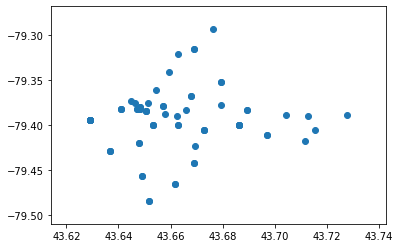

In [215]:
import matplotlib.pyplot as plt

plt.scatter(toronto['Latitude'], toronto['Longitude'])
plt.show()

In [216]:
from sklearn.cluster import KMeans

In [217]:
kmeans= KMeans(n_clusters=5)
model= kmeans.fit(toronto[['Latitude', 'Longitude']])
toronto['Labels']= model.labels_

In [218]:
toronto.shape

(74, 6)

In [239]:
import folium
colors= ['red', 'blue', 'green', 'purple', 'orange']
map_canada = folium.Map(location=[43.704324, -79.388790], zoom_start=11)
for idx in range(toronto.shape[0]):
    folium.CircleMarker(
        toronto.iloc[idx][['Latitude', 'Longitude']],
        radius=2,
        popup=toronto.iloc[idx]['Borough'],
        color=colors[toronto.iloc[idx]['Labels']],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  


In [247]:
map_canada

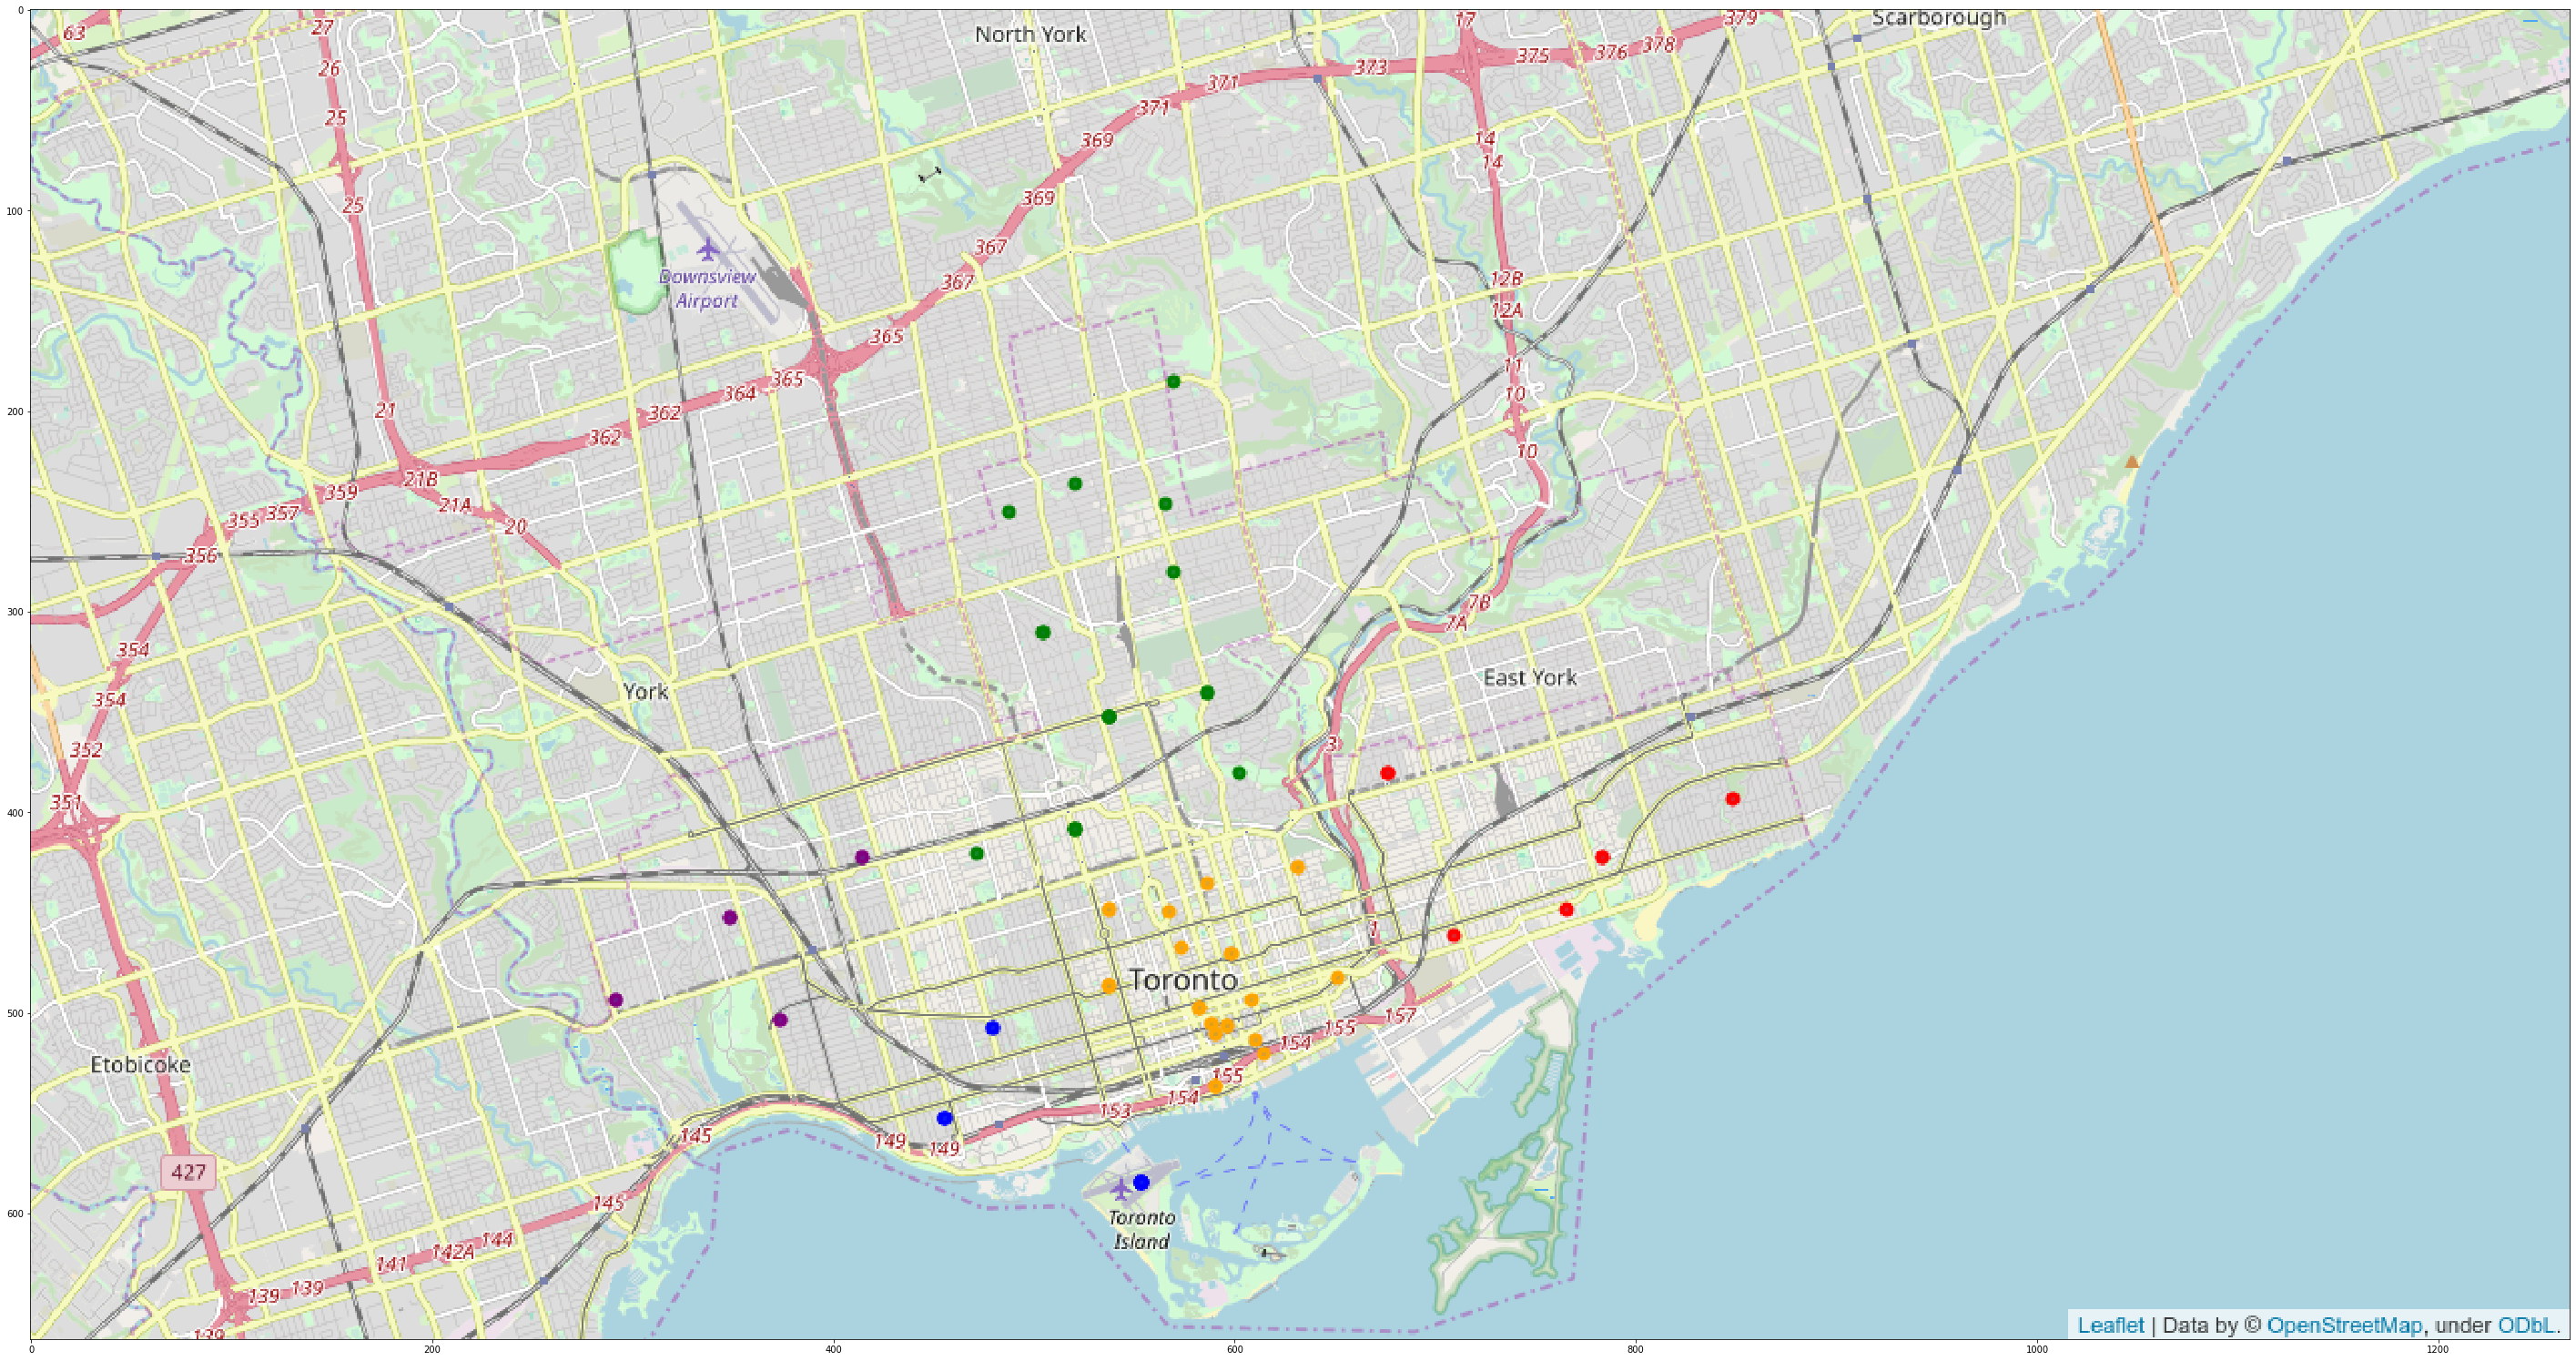

In [250]:
import matplotlib.image as mpimg
plt.figure(figsize= (50, 50))
plt.imshow(mpimg.imread('canada.png'))